## PlainTree files names 

In [1]:
#PLAINTREE FILES NAMES
directory='E:\\gsi-backup\machine learning\plainTrees_xi\data_URQMD_cutOnLambdaInvMass_5sigma\\'
directorySIG='E:\\gsi-backup\machine learning\plainTrees_xi\data_for_cutOnLambdaInvMass_5sigma\\'
signalFileName = directorySIG + 'PlainTree_xi_cutLambdaInvMass5_signal5M.root'
backgroundFileName = directory + 'PlainTree_xi_cutInvmass5_background500k_URQMD.root'
allFileName = directory + 'PlainTree_xi_cutInvmass5_sigbg500k_URQMD_2.root'

In [2]:
%%capture
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install

C:\Users\Małgorzata\Desktop\JupyterNotebook\CBM_ML_Lambda_Library


fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.


Already up to date.

From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD



running install
running bdist_egg
running egg_info
writing CBM_ML.egg-info\PKG-INFO
writing dependency_links to CBM_ML.egg-info\dependency_links.txt
writing top-level names to CBM_ML.egg-info\top_level.txt
reading manifest file 'CBM_ML.egg-info\SOURCES.txt'
writing manifest file 'CBM_ML.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\KFPF_lambda_cuts.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\plot_tools.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\root_functions.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\tree_importer.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\__init__.py -> build\bdist.win-amd64\egg\CBM_ML
byte-compiling build\bdist.win-amd64\egg\CBM_ML\KFPF_lambda_cuts.py to KFPF_lambda_cuts.cpython-38.pyc
byte-compiling build\bdist.win-am

zip_safe flag not set; analyzing archive contents...


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from CBM_ML import tree_importer,  KFPF_lambda_cuts, plot_tools
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

import gc, os

# Selecting Background and Signal
We generate PlainTrees from: 100k events (signal) and 20k evenents (background) with Au-Au @12A GeV/c, DCMQGSM-SMM generator passed through CBM setup in GEANT4, without any cuts

To omit imbalance classification problem (event though there are 5 times more events for background, the number of entries is much smaller for signal) we resample the data. We're deleting instances from the over-represented class (in our case the background) - it's called under-sampling, one of the resampling methods.

So for training and testing we will get signal candidates from the 5 sigma region and background from outside this region (3 times signal size).

In [4]:
#CUTS FOR MASS SELECTION
# +/-5 sigma region from the peak for signal
lowerCutSign = 1.2746
upperCutSign = 1.3688
#mean invariant mass
invMass = 1.3217
# cut region for background
lowerCutBckgr = 1.254
upperCutBckgr = 2.0

In [5]:
# We import three root files into our jupyter notebook
#sign - before cleaning but after 5sigma seletion, signal - cleaned
#so that we dont have to reimport everything with each change
sign = tree_importer.tree_importer(signalFileName,'plain_tree',7)

# We only select Xi- candidates in the 5 sigma region around the Xi- invariant mass peak //NOT YET!!!!!
#we preserve the cleaned dataframe with a changed name
sign = sign[(sign['Complex_generation']==1) & (sign['Complex_pid']==3312) & (sign['Complex_mass']>lowerCutSign) & (sign['Complex_mass']<upperCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the lambda peak
bckgr = tree_importer.tree_importer(backgroundFileName,'plain_tree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = bckgr[(bckgr['Complex_generation'] < 1)
                 & (bckgr['Complex_pid']==3312)
                 & ((bckgr['Complex_mass'] > lowerCutBckgr)
                 & (bckgr['Complex_mass'] < lowerCutSign) | (bckgr['Complex_mass']>upperCutSign) 
                    & (bckgr['Complex_mass'] < upperCutBckgr))].sample(n=5*(sign.shape[0]))

#Also call the garbage collector of python to collect unused items to free memory
gc.collect()

2892

In [6]:
#we remove name prefixes 'Candidates'
bckgr.columns = bckgr.columns.str.replace('Complex_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Complex_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['lambdachi2geo','lambdachi2primfirst','lambdachi2primsecond', 'lambdachi2topo','lambdacosinefirst', 'lambdacosinesecond', 'lambdacosinetopo', 'lambdadistance', 'lambdal', 'lambdaloverdl', 'lambdamassbeforeconstraint','lambdapx', 'lambdapy', 'lambdapz', 'geantprocessid', 'lambdageantprocessid', 'lambdageneration', 'pid']).rename(columns={'generation' : 'issignal'})
bckgr = bckgr.drop(columns=['lambdachi2geo','lambdachi2primfirst','lambdachi2primsecond', 'lambdachi2topo','lambdacosinefirst', 'lambdacosinesecond', 'lambdacosinetopo', 'lambdadistance', 'lambdal', 'lambdaloverdl', 'lambdamassbeforeconstraint','lambdapx', 'lambdapy', 'lambdapz', 'geantprocessid','lambdageantprocessid', 'lambdageneration', 'pid']).rename(columns={'generation' : 'issignal'})
#let's check the name prefixes
sign.iloc[0:2,:]

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,loverdl,mass,p,pT,phi,px,py,pz,rapidity,issignal
0,0.180670,16657.328125,269.413086,0.301693,0.99983,0.999983,0.999978,0.027072,2.148147,25.875088,30.004978,1.317334,5.463093,1.257957,1.485262,0.107468,1.253358,5.316289,1.792402,1.0
1,0.521517,26654.468750,5865.953125,1.255839,0.99268,0.999371,0.999966,0.042823,1.681263,21.886736,108.163139,1.323679,3.903159,1.404399,-0.177604,1.382308,-0.248118,3.641746,1.391939,1.0


# Data cleaning

In [7]:
#CUTS USED FOR DATA CLEANING
#mass cuts for both bckgr and sign
lowerMassCut = 1.254 #threshold area (lambda mass + pion- mass)
upperMassCut = 2.0
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = -5
upperLCut = 80
#loverdl
lowerLdlCut = -25
upperLdlCut = 15000
#coordinate cuts -> I do not have them here!
absXCut = 50
absYCut = 50
lowerZCut = -1
upperZCut = 80
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 100000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 1e8
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 1e8
#pseudorapidity cuts
lowerEtaCut = 1.
upperEtaCut = 6.5

In [8]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
#    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
    is_good_params = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) & (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) & (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)& (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimFirstCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimSecondCut)
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)

    is_good_df = (is_good_mom) & (is_good_params) & (is_good_daughters) & (is_good_mass)

    return df[is_good_df]

In [9]:
background = clean_df(bckgr)
signal = clean_df(sign)
print('size of:\nsignal: ' + str(len(signal)) + '\nbackground: ' + str(len(background)) 
      + '\nbackground to signal ratio: ' + str(round(len(background)/len(signal), 1)))
del sign, bckgr

size of:
signal: 49597
background: 231712
background to signal ratio: 4.7


In [10]:
#Let's combine signal and background
df_scaled = pd.concat([signal, background])
del signal, background
gc.collect()

72

After cleaning, our training data set contains 450442 background candidates and 1638402XX signal candidates (background to signal ratio $\approx 3.6XX$). For testing, we'll use cleaned dataset containing 28740227XX entries of signal and background (background to signal ratio $\approx 1985.1XX$)

Here, we use under-sampling to tackle the problem with the classification of underrepresented class (normally, the signal is only approx. 0.05% of real data)

In [11]:
if not os.path.exists(directory+'img/xgb_v3'):
    os.makedirs(directory+'img/xgb_v3')
#lets draw sign to background ratio
def plt_sig_back(df):
    range1 = (lowerMassCut, upperMassCut)
    fig, axs = plt.subplots(figsize=(20, 10))
    #df_scaled['mass'].plot.hist(bins = 300, range=range1,grid=True,sharey=True)
    (df[df['issignal']==0])['mass'].plot.hist(bins = 300, facecolor='yellow',grid=True,range=range1, label='Background')
    (df[df['issignal']==1])['mass'].plot.hist(bins = 300, facecolor='magenta',grid=True, range=range1, label ='Signal')
    #plt.vlines(x=1.108,ymin=-1,ymax=48000, color='black', linestyle='-')
    #plt.vlines(x=1.1227,ymin=-1,ymax=48000, color='black', linestyle='-')
    plt.ylabel("Counts (log scale)", fontsize=15)
    plt.xlabel("Mass (GeV/$c^2$)", fontsize= 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Test and Train $\Xi^{-}$ Invariant Mass', fontsize = 15)
    plt.legend( fontsize = 15)
    axs.tick_params(axis='both', which='major', labelsize=18)
    plt.yscale("log")
    fig.tight_layout()
    fig.savefig(directory+'img/xgb_v3/inv_mass_trainset.pdf')
    fig.savefig(directory+'img/xgb_v3/inv_mass_trainset.png')

0

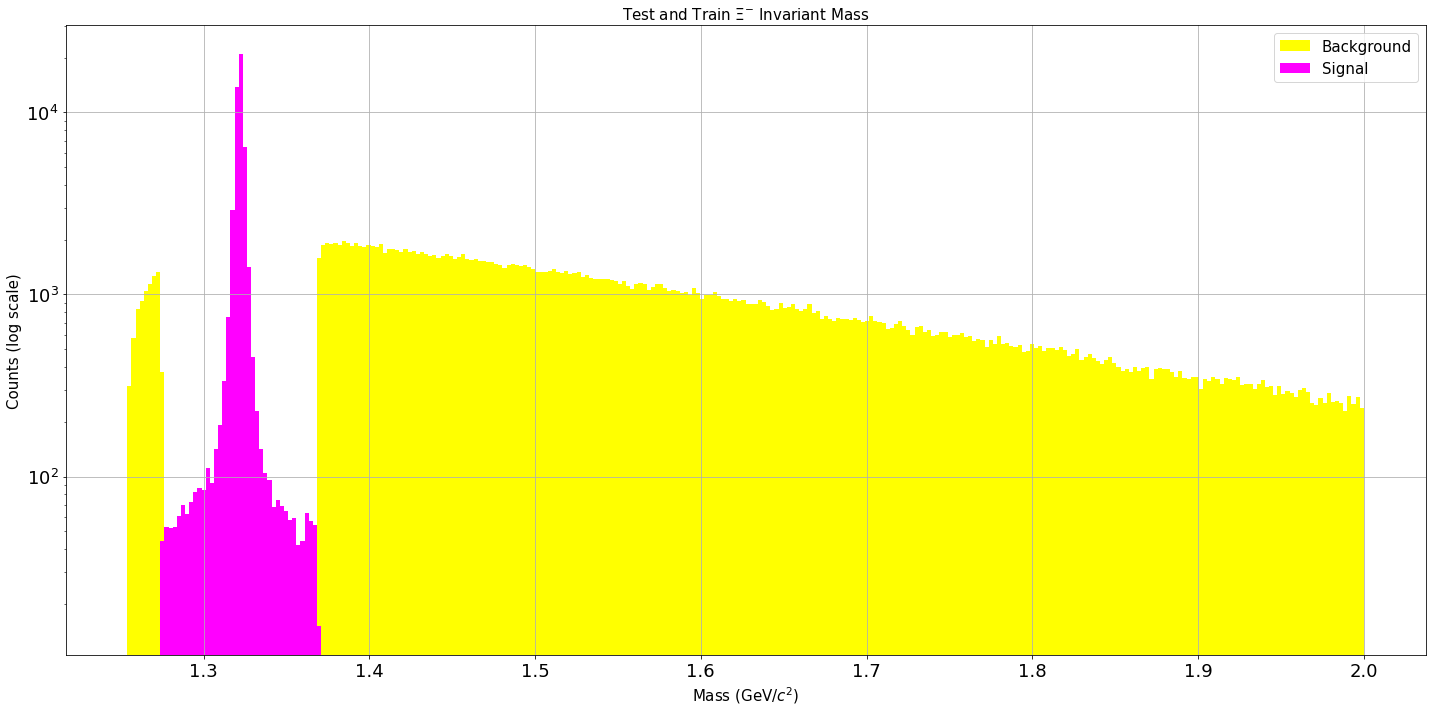

In [12]:
plt_sig_back(df_scaled)
gc.collect()

# Creating Train and Test sets
To make machine learning algorithms more efficient on unseen data we divide our data into two sets. One set is for training the algorithm and the other is for testing the algorithm. If we don't do this then the algorithm can overfit and we will not capture the general trends in the data.

In [13]:
# The following columns will be used to predict whether a reconstructed candidate is a Xi- particle or not
cuts = [ 'loverdl', 'distance', 'chi2geo', 'chi2topo', 'chi2primfirst', 'chi2primsecond']


x = df_scaled[cuts].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(df_scaled['issignal'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=324)
del df_scaled, x, y

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest1=xgb.DMatrix(x_test, label = y_test)
del x_train, x_test
gc.collect()

53491

# Bayesian optimization
In order to find the best parameters of XGB for our data we use Bayesian optimization. Grid search and and random search could also do the same job but bayesian is more time efficient. For further reading visit the git page of the bayesian optimization used here.

Hyper parameters
Some of the following hyper parameters will be tuned for our algorithm:

subsample [default=1] Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. range: (0,1]

eta [default=0.3, alias: learning_rate] Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. range: [0,1]

gamma [default=0, alias: min_split_loss] Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. range: [0,∞]

alpha [default=0, alias: reg_alpha] L1 regularization term on weights. Increasing this value will make model more conservative.

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [14]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'auc', 'nthread' : 7}
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]

bounds_transformer = SequentialDomainReductionTransformer()

In [15]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,1000)
                                            },
                             bounds_transformer=bounds_transformer)

In [16]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5)

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
[20:17:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 142 pruned nodes, max_depth=9
[20:17:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 136 pruned nodes, max_depth=9
[20:17:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 152 pruned nodes, max_depth=9
[20:17:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 156 pruned nodes, max_depth=9
[20:17:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 170 pruned nodes, max_depth=9
[20:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree

[20:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 206 pruned nodes, max_depth=9
[20:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 288 pruned nodes, max_depth=9
[20:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 212 pruned nodes, max_depth=9
[20:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 344 pruned nodes, max_depth=9
[20:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 212 pruned nodes, max_depth=9
[20:17:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 318 pruned nodes, max_depth=9
[20:17:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:17:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 382 pruned nodes, max_depth=7
[20:17:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 426 pruned nodes, max_depth=9
[20:18:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 468 pruned nodes, max_depth=0
[20:18:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 462 pruned nodes, max_depth=9
[20:18:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 392 pruned nodes, max_depth=6
[20:18:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 330 pruned nodes, max_depth=9
[20:18:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[20:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 424 pruned nodes, max_depth=0
[20:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 386 pruned nodes, max_depth=7
[20:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 384 pruned nodes, max_depth=0
[20:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 148 pruned nodes, max_depth=0
[20:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 320 pruned nodes, max_depth=9
[20:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 292 pruned nodes, max_depth=4
[20:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[20:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 324 pruned nodes, max_depth=0
[20:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 238 pruned nodes, max_depth=0
[20:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 358 pruned nodes, max_depth=9
[20:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 286 pruned nodes, max_depth=0
[20:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 284 pruned nodes, max_depth=9
[20:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 296 pruned nodes, max_depth=5
[20:18:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:18:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 408 pruned nodes, max_depth=6
[20:18:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 260 pruned nodes, max_depth=4
[20:18:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 234 pruned nodes, max_depth=0
[20:18:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 456 pruned nodes, max_depth=6
[20:18:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 206 pruned nodes, max_depth=0
[20:18:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 250 pruned nodes, max_depth=9
[20:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 410 pruned nodes, max_depth=8
[20:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 438 pruned nodes, max_depth=0
[20:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 550 pruned nodes, max_depth=0
[20:18:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 226 pruned nodes, max_depth=7
[20:18:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 304 pruned nodes, max_depth=6
[20:18:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 280 pruned nodes, max_depth=0
[20:18:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:19:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[20:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[20:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=3
[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[20:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[20:19:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[20:19:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20:19:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[20:19:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[20:19:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[20:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[20:19:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20:19:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[20:19:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[20:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[20:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[20:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[20:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[20:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[20:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[20:19:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[20:19:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[20:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[20:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[20:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[20:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[20:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[20:19:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 110 pruned nodes, max_depth=8
[20:19:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 142 pruned nodes, max_depth=8
[20:19:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 130 pruned nodes, max_depth=8
[20:19:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 124 pruned nodes, max_depth=8
[20:19:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 96 pruned nodes, max_depth=8
[20:19:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 102 pruned nodes, max_depth=8
[20:19:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[20:19:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 224 pruned nodes, max_depth=7
[20:19:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 256 pruned nodes, max_depth=8
[20:19:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 218 pruned nodes, max_depth=8
[20:19:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 270 pruned nodes, max_depth=0
[20:19:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 292 pruned nodes, max_depth=0
[20:19:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 280 pruned nodes, max_depth=7
[20:19:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[20:20:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 252 pruned nodes, max_depth=7
[20:20:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 160 pruned nodes, max_depth=6
[20:20:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 242 pruned nodes, max_depth=5
[20:20:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 272 pruned nodes, max_depth=7
[20:20:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 214 pruned nodes, max_depth=0
[20:20:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 216 pruned nodes, max_depth=0
[20:20:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[20:20:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 196 pruned nodes, max_depth=0
[20:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 112 pruned nodes, max_depth=0
[20:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 230 pruned nodes, max_depth=0
[20:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 200 pruned nodes, max_depth=0
[20:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 280 pruned nodes, max_depth=0
[20:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 170 pruned nodes, max_depth=0
[20:20:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:20:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 164 pruned nodes, max_depth=0
[20:20:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 178 pruned nodes, max_depth=0
[20:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 264 pruned nodes, max_depth=8
[20:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 186 pruned nodes, max_depth=0
[20:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 230 pruned nodes, max_depth=0
[20:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 228 pruned nodes, max_depth=0
[20:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[20:20:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 170 pruned nodes, max_depth=0
[20:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 176 pruned nodes, max_depth=0
[20:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 224 pruned nodes, max_depth=0
[20:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 268 pruned nodes, max_depth=0
[20:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 220 pruned nodes, max_depth=0
[20:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 150 pruned nodes, max_depth=0
[20:20:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:20:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 202 pruned nodes, max_depth=0
[20:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 190 pruned nodes, max_depth=7
[20:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 200 pruned nodes, max_depth=0
[20:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 236 pruned nodes, max_depth=0
[20:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 264 pruned nodes, max_depth=0
[20:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 248 pruned nodes, max_depth=7
[20:20:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[20:21:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 24 pruned nodes, max_depth=7
[20:21:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 38 pruned nodes, max_depth=7
[20:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 32 pruned nodes, max_depth=7
[20:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 30 pruned nodes, max_depth=7
[20:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 30 pruned nodes, max_depth=7
[20:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 32 pruned nodes, max_depth=7
[20:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:21:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 56 pruned nodes, max_depth=7
[20:21:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 62 pruned nodes, max_depth=7
[20:21:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 64 pruned nodes, max_depth=7
[20:21:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 66 pruned nodes, max_depth=7
[20:21:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 56 pruned nodes, max_depth=7
[20:21:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 82 pruned nodes, max_depth=7
[20:21:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 76 pruned nodes, max_depth=7
[20:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 82 pruned nodes, max_depth=7
[20:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 66 pruned nodes, max_depth=7
[20:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 82 pruned nodes, max_depth=7
[20:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 76 pruned nodes, max_depth=7
[20:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 54 pruned nodes, max_depth=7
[20:21:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:21:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 64 pruned nodes, max_depth=7
[20:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=7
[20:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 92 pruned nodes, max_depth=7
[20:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 48 pruned nodes, max_depth=7
[20:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 56 pruned nodes, max_depth=7
[20:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 54 pruned nodes, max_depth=7
[20:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:21:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 112 pruned nodes, max_depth=7
[20:21:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 104 pruned nodes, max_depth=3
[20:21:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 86 pruned nodes, max_depth=7
[20:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 88 pruned nodes, max_depth=7
[20:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=7
[20:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 70 pruned nodes, max_depth=7
[20:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[20:21:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 92 pruned nodes, max_depth=7
[20:21:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 88 pruned nodes, max_depth=7
[20:21:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 66 pruned nodes, max_depth=7
[20:21:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 80 pruned nodes, max_depth=7
[20:21:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 58 pruned nodes, max_depth=7
[20:21:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 90 pruned nodes, max_depth=7
[20:21:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[20:22:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 140 pruned nodes, max_depth=9
[20:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 138 pruned nodes, max_depth=9
[20:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 104 pruned nodes, max_depth=9
[20:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 78 pruned nodes, max_depth=9
[20:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 136 pruned nodes, max_depth=9
[20:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 98 pruned nodes, max_depth=9
[20:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: t

[20:22:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 114 pruned nodes, max_depth=9
[20:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 96 pruned nodes, max_depth=9
[20:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 130 pruned nodes, max_depth=9
[20:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 134 pruned nodes, max_depth=9
[20:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 66 pruned nodes, max_depth=9
[20:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 156 pruned nodes, max_depth=7
[20:22:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[20:22:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 114 pruned nodes, max_depth=9
[20:22:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 170 pruned nodes, max_depth=9
[20:22:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 138 pruned nodes, max_depth=9
[20:22:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 118 pruned nodes, max_depth=7
[20:22:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 158 pruned nodes, max_depth=8
[20:22:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 146 pruned nodes, max_depth=9
[20:22:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:22:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 136 pruned nodes, max_depth=9
[20:22:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 102 pruned nodes, max_depth=9
[20:22:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 158 pruned nodes, max_depth=9
[20:22:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 100 pruned nodes, max_depth=9
[20:22:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 94 pruned nodes, max_depth=9
[20:22:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 140 pruned nodes, max_depth=8
[20:22:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[20:22:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 124 pruned nodes, max_depth=8
[20:22:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 154 pruned nodes, max_depth=9
[20:22:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 128 pruned nodes, max_depth=5
[20:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 90 pruned nodes, max_depth=9
[20:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 118 pruned nodes, max_depth=9
[20:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 144 pruned nodes, max_depth=9
[20:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[20:23:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 148 pruned nodes, max_depth=7
[20:23:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 132 pruned nodes, max_depth=9
[20:23:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 142 pruned nodes, max_depth=9
[20:23:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 104 pruned nodes, max_depth=9
[20:23:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 126 pruned nodes, max_depth=9
[20:23:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 152 pruned nodes, max_depth=9
[20:23:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 156 pruned nodes, max_depth=6
[20:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 160 pruned nodes, max_depth=8
[20:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 152 pruned nodes, max_depth=9
|  5        |  0.9904   |  11.78    |  0.135    |  0.6745   |  9.437    |  344.7    |
[20:23:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 80 pruned nodes, max_depth=8
[20:23:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 72 pruned nodes, max_depth=8
[20:23:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 80 pruned nodes, max_dept

[20:23:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 182 pruned nodes, max_depth=8
[20:23:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 180 pruned nodes, max_depth=8
[20:23:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 180 pruned nodes, max_depth=7
[20:23:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 252 pruned nodes, max_depth=8
[20:23:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 168 pruned nodes, max_depth=8
[20:23:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 202 pruned nodes, max_depth=8
[20:23:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:23:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 300 pruned nodes, max_depth=6
[20:23:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 268 pruned nodes, max_depth=6
[20:23:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 138 pruned nodes, max_depth=0
[20:23:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 194 pruned nodes, max_depth=8
[20:23:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 246 pruned nodes, max_depth=6
[20:23:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 308 pruned nodes, max_depth=0
[20:23:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[20:23:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 288 pruned nodes, max_depth=7
[20:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 318 pruned nodes, max_depth=8
[20:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 224 pruned nodes, max_depth=0
[20:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 184 pruned nodes, max_depth=0
[20:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 274 pruned nodes, max_depth=8
[20:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 198 pruned nodes, max_depth=0
[20:23:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:24:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 212 pruned nodes, max_depth=0
[20:24:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 204 pruned nodes, max_depth=8
[20:24:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 256 pruned nodes, max_depth=8
[20:24:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 330 pruned nodes, max_depth=5
[20:24:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 240 pruned nodes, max_depth=7
[20:24:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 350 pruned nodes, max_depth=0
[20:24:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[20:24:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 186 pruned nodes, max_depth=0
[20:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 280 pruned nodes, max_depth=0
[20:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 250 pruned nodes, max_depth=6
[20:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 166 pruned nodes, max_depth=6
[20:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 340 pruned nodes, max_depth=7
[20:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 308 pruned nodes, max_depth=0
[20:24:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:24:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 204 pruned nodes, max_depth=8
[20:24:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 222 pruned nodes, max_depth=0
[20:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 248 pruned nodes, max_depth=4
[20:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 210 pruned nodes, max_depth=6
[20:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 224 pruned nodes, max_depth=0
[20:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 250 pruned nodes, max_depth=8
[20:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:24:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 278 pruned nodes, max_depth=9
[20:24:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 246 pruned nodes, max_depth=9
[20:24:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 216 pruned nodes, max_depth=9
[20:24:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 224 pruned nodes, max_depth=9
[20:24:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 224 pruned nodes, max_depth=9
[20:24:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 252 pruned nodes, max_depth=9
[20:24:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:

[20:24:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 254 pruned nodes, max_depth=9
[20:24:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 298 pruned nodes, max_depth=9
[20:24:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 266 pruned nodes, max_depth=9
[20:24:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 282 pruned nodes, max_depth=9
[20:24:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 288 pruned nodes, max_depth=9
[20:24:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 372 pruned nodes, max_depth=9
[20:24:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: 

[20:25:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 420 pruned nodes, max_depth=8
[20:25:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 384 pruned nodes, max_depth=9
[20:25:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 268 pruned nodes, max_depth=9
[20:25:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 282 pruned nodes, max_depth=9
[20:25:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 390 pruned nodes, max_depth=9
[20:25:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 366 pruned nodes, max_depth=8
[20:25:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:25:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 504 pruned nodes, max_depth=8
[20:25:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 546 pruned nodes, max_depth=7
[20:25:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 346 pruned nodes, max_depth=9
[20:25:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 444 pruned nodes, max_depth=9
[20:25:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 382 pruned nodes, max_depth=9
[20:25:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 406 pruned nodes, max_depth=7
[20:25:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:25:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 374 pruned nodes, max_depth=9
[20:25:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 384 pruned nodes, max_depth=9
[20:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 364 pruned nodes, max_depth=8
[20:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 390 pruned nodes, max_depth=5
[20:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 298 pruned nodes, max_depth=9
[20:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 490 pruned nodes, max_depth=9
[20:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:25:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 432 pruned nodes, max_depth=9
[20:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 356 pruned nodes, max_depth=9
[20:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 398 pruned nodes, max_depth=9
[20:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 538 pruned nodes, max_depth=6
[20:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 330 pruned nodes, max_depth=0
[20:25:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 500 pruned nodes, max_depth=8
[20:25:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[20:25:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 204 pruned nodes, max_depth=9
[20:25:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 178 pruned nodes, max_depth=9
[20:25:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 204 pruned nodes, max_depth=9
[20:25:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 188 pruned nodes, max_depth=9
[20:25:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 200 pruned nodes, max_depth=9
[20:25:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 172 pruned nodes, max_depth=9
[20:25:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:

[20:26:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 214 pruned nodes, max_depth=9
[20:26:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 226 pruned nodes, max_depth=9
[20:26:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 236 pruned nodes, max_depth=9
[20:26:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 230 pruned nodes, max_depth=9
[20:26:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 280 pruned nodes, max_depth=9
[20:26:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 222 pruned nodes, max_depth=9
[20:26:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:

[20:26:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 264 pruned nodes, max_depth=9
[20:26:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 288 pruned nodes, max_depth=9
[20:26:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 246 pruned nodes, max_depth=9
[20:26:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 270 pruned nodes, max_depth=9
[20:26:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 250 pruned nodes, max_depth=9
[20:26:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 210 pruned nodes, max_depth=9
[20:26:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74

[20:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 298 pruned nodes, max_depth=9
[20:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 246 pruned nodes, max_depth=9
[20:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 230 pruned nodes, max_depth=9
[20:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 230 pruned nodes, max_depth=9
[20:26:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 282 pruned nodes, max_depth=9
[20:26:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 252 pruned nodes, max_depth=9
[20:26:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: t

[20:26:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 288 pruned nodes, max_depth=9
[20:26:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 314 pruned nodes, max_depth=9
[20:26:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 296 pruned nodes, max_depth=9
[20:26:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 290 pruned nodes, max_depth=9
[20:26:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 240 pruned nodes, max_depth=9
[20:26:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 326 pruned nodes, max_depth=9
[20:26:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:26:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 256 pruned nodes, max_depth=9
[20:26:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 316 pruned nodes, max_depth=9
[20:26:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 232 pruned nodes, max_depth=9
[20:26:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 340 pruned nodes, max_depth=9
[20:26:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 334 pruned nodes, max_depth=9
[20:26:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 344 pruned nodes, max_depth=9
[20:26:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: t

[20:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 286 pruned nodes, max_depth=9
[20:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 376 pruned nodes, max_depth=9
[20:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 354 pruned nodes, max_depth=9
[20:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 438 pruned nodes, max_depth=9
[20:26:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 302 pruned nodes, max_depth=9
[20:26:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 394 pruned nodes, max_depth=9
[20:26:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:27:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 174 pruned nodes, max_depth=9
[20:27:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 154 pruned nodes, max_depth=9
[20:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 162 pruned nodes, max_depth=9
[20:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 158 pruned nodes, max_depth=9
[20:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 166 pruned nodes, max_depth=9
[20:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 172 pruned nodes, max_depth=9
[20:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:27:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 318 pruned nodes, max_depth=9
[20:27:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 250 pruned nodes, max_depth=9
[20:27:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 294 pruned nodes, max_depth=9
[20:27:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 314 pruned nodes, max_depth=9
[20:27:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 416 pruned nodes, max_depth=7
[20:27:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 382 pruned nodes, max_depth=8
[20:27:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:27:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 284 pruned nodes, max_depth=9
[20:27:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 370 pruned nodes, max_depth=4
[20:27:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 278 pruned nodes, max_depth=9
[20:27:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 320 pruned nodes, max_depth=0
[20:27:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 320 pruned nodes, max_depth=9
[20:27:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 346 pruned nodes, max_depth=8
[20:27:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[20:27:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 388 pruned nodes, max_depth=9
[20:27:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 346 pruned nodes, max_depth=7
[20:27:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 304 pruned nodes, max_depth=8
[20:27:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 282 pruned nodes, max_depth=0
[20:27:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 158 pruned nodes, max_depth=9
[20:27:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 360 pruned nodes, max_depth=4
[20:27:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[20:27:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 300 pruned nodes, max_depth=0
[20:27:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 380 pruned nodes, max_depth=8
[20:27:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 348 pruned nodes, max_depth=0
[20:27:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 328 pruned nodes, max_depth=6
[20:27:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 332 pruned nodes, max_depth=0
[20:27:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 432 pruned nodes, max_depth=0
[20:27:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[20:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 368 pruned nodes, max_depth=0
[20:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 314 pruned nodes, max_depth=7
[20:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 384 pruned nodes, max_depth=0
[20:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 226 pruned nodes, max_depth=0
[20:28:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 220 pruned nodes, max_depth=0
[20:28:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 338 pruned nodes, max_depth=7
[20:28:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[20:28:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 162 pruned nodes, max_depth=8
[20:28:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 140 pruned nodes, max_depth=8
[20:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 158 pruned nodes, max_depth=8
[20:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 144 pruned nodes, max_depth=8
[20:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 140 pruned nodes, max_depth=8
[20:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 146 pruned nodes, max_depth=8
[20:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:

[20:28:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 222 pruned nodes, max_depth=8
[20:28:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 212 pruned nodes, max_depth=8
[20:28:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 196 pruned nodes, max_depth=8
[20:28:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 210 pruned nodes, max_depth=8
[20:28:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 172 pruned nodes, max_depth=8
[20:28:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 172 pruned nodes, max_depth=8
[20:28:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:28:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 254 pruned nodes, max_depth=8
[20:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 260 pruned nodes, max_depth=8
[20:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 302 pruned nodes, max_depth=8
[20:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 294 pruned nodes, max_depth=8
[20:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 238 pruned nodes, max_depth=8
[20:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 204 pruned nodes, max_depth=8
[20:28:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 340 pruned nodes, max_depth=6
[20:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 264 pruned nodes, max_depth=8
[20:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 234 pruned nodes, max_depth=8
[20:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 296 pruned nodes, max_depth=8
[20:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 236 pruned nodes, max_depth=8
[20:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 280 pruned nodes, max_depth=8
[20:28:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:29:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 276 pruned nodes, max_depth=8
[20:29:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 174 pruned nodes, max_depth=8
[20:29:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 354 pruned nodes, max_depth=0
[20:29:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 246 pruned nodes, max_depth=0
[20:29:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 282 pruned nodes, max_depth=0
[20:29:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 224 pruned nodes, max_depth=0
[20:29:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[20:29:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 278 pruned nodes, max_depth=0
[20:29:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 160 pruned nodes, max_depth=7
[20:29:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 144 pruned nodes, max_depth=8
[20:29:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 118 pruned nodes, max_depth=8
[20:29:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 210 pruned nodes, max_depth=0
[20:29:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 232 pruned nodes, max_depth=4
[20:29:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[20:29:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 314 pruned nodes, max_depth=6
[20:29:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 330 pruned nodes, max_depth=6
[20:29:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 314 pruned nodes, max_depth=0
[20:29:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 150 pruned nodes, max_depth=7
[20:29:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 224 pruned nodes, max_depth=0
[20:29:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 268 pruned nodes, max_depth=0
[20:29:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

In [17]:
# best target so far: ....
print(xgb_bo.max)

{'target': 0.9947312, 'params': {'alpha': 2.055211961921435, 'gamma': 0.902024974510493, 'learning_rate': 0.046955294684024464, 'max_depth': 9.218186129509103, 'n_estimators': 739.3667720614521}}


In [18]:
max_params = xgb_bo.max
print(max_params)

{'target': 0.9947312, 'params': {'alpha': 2.055211961921435, 'gamma': 0.902024974510493, 'learning_rate': 0.046955294684024464, 'max_depth': 9.218186129509103, 'n_estimators': 739.3667720614521}}


# XGB models
Now let's take the parameters selected by the bayesian optimization and apply them in our training and testing.

In [19]:
#max_param = xgb_bo.max['params']
max_param = max_params['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'], 'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 'objective': 'reg:logistic'}

In [20]:
#To train the algorithm using the parameters selected by bayesian optimization
bst = xgb.train(param, dtrain)

[20:29:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 52 pruned nodes, max_depth=9
[20:29:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 54 pruned nodes, max_depth=9
[20:29:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 50 pruned nodes, max_depth=9
[20:29:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 54 pruned nodes, max_depth=9
[20:29:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 54 pruned nodes, max_depth=9
[20:29:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 60 pruned nodes, max_depth=9
[20:29:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

In [21]:
#We apply our model on the training data that was trained on the training data, this helps us to control overfitting
bst1= bst.predict(dtrain)

In [22]:
del dtrain 
gc.collect()

197

In [23]:
# We apply our trained model on test data and store the predictions in a bst_test dataframe
bst_test = pd.DataFrame(data=bst.predict(dtest1),  columns=["xgb_preds"])
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
# We also store the MC information in this dataFrame
bst_test['issignal']=y_test['issignal']

In [24]:
df_origin = tree_importer.tree_importer(allFileName,'plain_tree',7)
df_origin.columns = df_origin.columns.str.replace('Complex_', '')
df_origin.columns = df_origin.columns.str.replace('_', '')
df_origin = df_origin.drop(columns=['lambdachi2geo','lambdachi2primfirst','lambdachi2primsecond', 'lambdachi2topo','lambdacosinefirst', 'lambdacosinesecond', 'lambdacosinetopo', 'lambdadistance', 'lambdal', 'lambdaloverdl', 'lambdamassbeforeconstraint','lambdapx', 'lambdapy', 'lambdapz', 'geantprocessid', 'lambdageantprocessid', 'lambdageneration', 'pid']).rename(columns={'generation' : 'issignal'})
df_clean = clean_df(df_origin)
del df_origin
gc.collect()
#lets look at impoted tree
df_clean.iloc[0:10,:]
print('test set (background to signal ratio): ' 
      + str(round(len(df_clean.loc[df_clean['issignal'] == 0])/len(df_clean.loc[df_clean['issignal'] == 1]), 1))
      + '\ntest set (both signal and background): ' + str(len(df_clean)))

test set (background to signal ratio): 806.7
test set (both signal and background): 5066431


In [25]:
x_whole = df_clean[cuts].copy()
y_whole = pd.DataFrame(df_clean['issignal'], dtype='int')
dtest = xgb.DMatrix(x_whole, label = y_whole)
del x_whole
gc.collect()

19

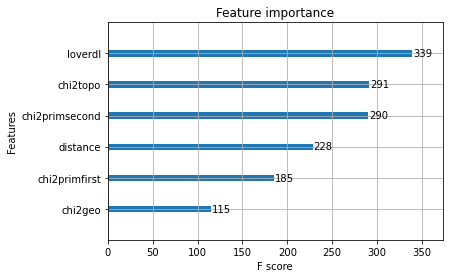

In [26]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
ax.figure.savefig(directory+'img/xgb_v3/feature_importance.pdf')
ax.figure.savefig(directory+'img/xgb_v3/feature_importance.png')

# AUC and ROC
The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

This function requires the true binary value and the target scores, which can either be probability estimates of the positive class, confidence values, or binary decisions.

Similarly, the function roc_auc_score computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

To find the best threshold which results more signal to background ratio for lambda candidates we use the parameter S0 called the approximate median significance by the higgs boson ML challenge (http://higgsml.lal.in2p3.fr/documentation,9.)

In [27]:
def AMS(y_true, y_predict, y_true1, y_predict1):
    roc_auc=roc_auc_score(y_true, y_predict)
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    S0 = S0[~np.isnan(S0)]
    xi = argmax(S0)
    S0_best_threshold = (thresholds[xi])

    roc_auc1=roc_auc_score(y_true1, y_predict1)
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    S01 = S01[~np.isnan(S01)]
    xi1 = argmax(S01)
    S0_best_threshold1 = (thresholds[xi1])

    #plotting
    fig, axs = plt.subplots(figsize=(12, 8), dpi = 100)
    plt.plot(fpr, tpr, linestyle=':',color='darkorange',label='ROC curve train (area = %0.4f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='green',label='ROC curve test (area = %0.4f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n S0 = '+ "%.2f" % S0[xi])
    plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n AMS = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.legend(loc="lower right", fontsize = 15)
    plt.title('Receiver operating characteristic', fontsize = 15)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    
    fig.tight_layout()
    plt.show()
    fig.savefig(directory+'img/xgb_v3/ams.pdf')
    fig.savefig(directory+'img/xgb_v3/ams.png')

    return S0_best_threshold, S0_best_threshold1

<ipython-input-27-89b152e96404>:4: RuntimeWarning: invalid value encountered in true_divide
  S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
<ipython-input-27-89b152e96404>:11: RuntimeWarning: invalid value encountered in true_divide
  S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))


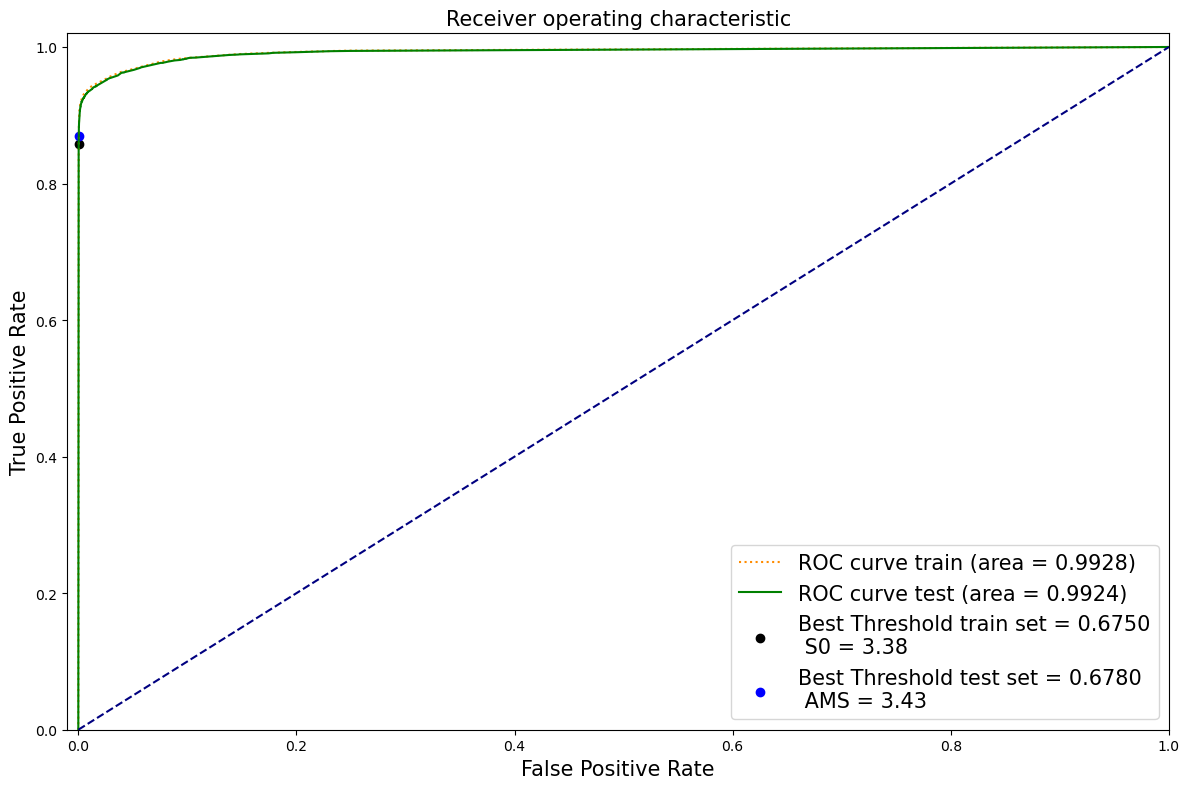

In [28]:
train_best, test_best = AMS(y_train, bst1, y_test, bst_test['xgb_preds'])

When the AUC, best threshold and approximate median significance for train and test are nearly the same, we save that model and use it. This means that our model is general enough. In my opinion, if the test S0 is above 3.0 then it is a good enough model.

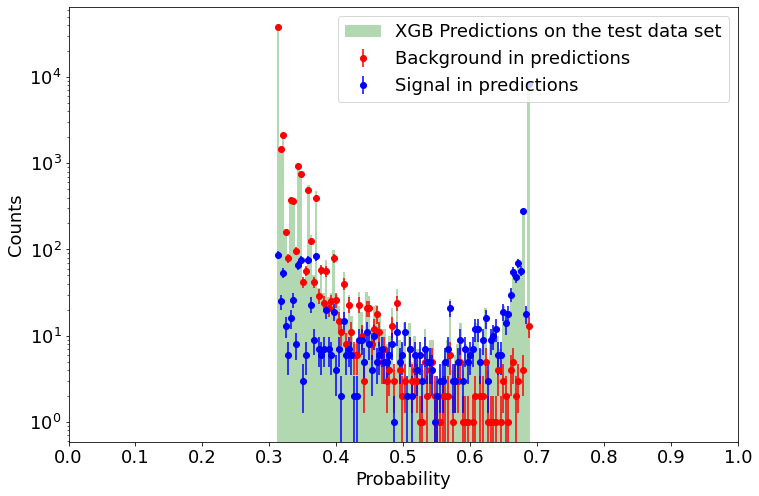

In [29]:
def preds_prob(df, preds, true, dataset):
    if dataset =='train':
        label1 = 'XGB Predictions on the training data set'
    else:
        label1 = 'XGB Predictions on the test data set'
    fig, ax = plt.subplots(figsize=(12, 8))
    bins1=100
    plt.hist(df[preds], bins=bins1,facecolor='green',alpha = 0.3, label=label1)
    TP = df[(df[true]==1)]
    TN = df[(df[true]==0)]
    #TP[preds].plot.hist(ax=ax, bins=bins1,facecolor='blue', histtype='stepfilled',alpha = 0.3, label='True Positives/signal in predictions')
    hist, bins = np.histogram(TP[preds], bins=bins1)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:]) / 2

    
    hist1, bins1 = np.histogram(TN[preds], bins=bins1)
    err1 = np.sqrt(hist1)
    plt.errorbar(center, hist1, yerr=err1, fmt='o',
                 c='Red', label='Background in predictions')
    
    plt.errorbar(center, hist, yerr=err, fmt='o',
                 c='blue', label='Signal in predictions')
    
    ax.set_yscale('log')
    plt.xlabel('Probability',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    plt.legend(fontsize=18)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.show()
    fig.tight_layout()
    fig.savefig('test_best.png')
preds_prob(bst_test,'xgb_preds', 'issignal','test')

In [30]:
df_clean['xgb_preds'] = bst.predict(dtest)

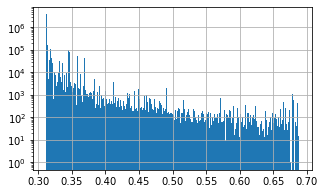

In [31]:
df_clean['xgb_preds'].hist(bins=300)
plt.yscale('log')

# Confusion Matrix
A Confusion Matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$

The following function prints and plots the confusion matrix. Normalization can be applied by setting normalize=True.

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

In [34]:
#calculate efficency and false tu tru signal ratio
def confustion_stats(df, cm):
    all_signals = len(df.loc[df['issignal'] == 1])
    true_signal = cm[0][0]
    false_signal = cm[1][0]        
    reconstructed_signals = true_signal + false_signal
    false_to_true_signals = false_signal / true_signal
    efficiency = reconstructed_signals / all_signals * 100 #efficency in % for all
    efficiency_true = true_signal / all_signals * 100 #efficency in % for all
    print("Efficiency: " + str(round(efficiency, 2)) + "%")
    print("Efficiency of true signal candidates reconstruction: " + str(round(efficiency_true, 2)) + "%")
    print("False tu true reconstructed signal ratio: " + str(round(false_to_true_signals, 2)))

Confusion matrix, without normalization
[[   5603     670]
 [   3315 5056833]]


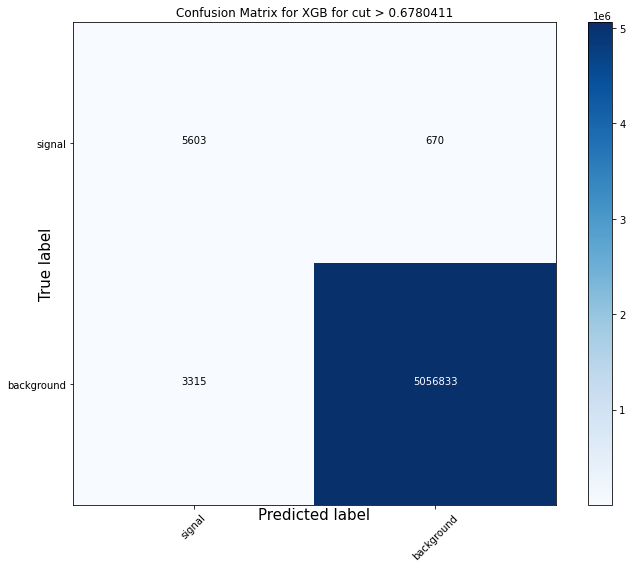

In [35]:
#lets take the best threshold and look at the confusion matrix
cut1 = test_best
df_clean['xgb_preds1'] = ((df_clean['xgb_preds']>cut1)*1)
cnf_matrix = confusion_matrix(y_whole, df_clean['xgb_preds1'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for XGB for cut > '+str(cut1))
fig.savefig(directory+'img/xgb_v3/confusion_matrix_extreme_gradient_boosting_whole_data.pdf')
fig.savefig(directory+'img/xgb_v3/confusion_matrix_extreme_gradient_boosting_whole_data.png')

In [36]:
confustion_stats(df_clean, cnf_matrix)

Efficiency: 142.16%
Efficiency of true signal candidates reconstruction: 89.32%
False tu true reconstructed signal ratio: 0.59


In [37]:
# The following function will display the inavriant mass histogram of the original 10k event set along with the mass histoigram after we apply a cut
# on the probability prediction of xgb
def cut_visualization(cut, range1=(lowerMassCut, upperMassCut), bins1= 300 ):
    mask1 = df_clean['xgb_preds']>cut
    df3=df_clean[mask1]
    
    fig, ax2 = plt.subplots(figsize=(15, 10), dpi = 200)
    color = 'tab:blue'
    ax2.hist(df_clean['mass'],bins = bins1, range=range1, facecolor='blue',alpha = 0.35, label='before selection')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc='upper left')
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label='XGB')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend( fontsize = 15,loc='upper right' )

    plt.title("The original sample's Invariant Mass along with mass after selection of XGB (with a cut > "+str(cut)+')', fontsize = 15)
    fig.tight_layout()
    fig.savefig(directory+'img/xgb_v3/whole_sample_invmass_with_ML.pdf')
    fig.savefig(directory+'img/xgb_v3/whole_sample_invmass_with_ML.png')

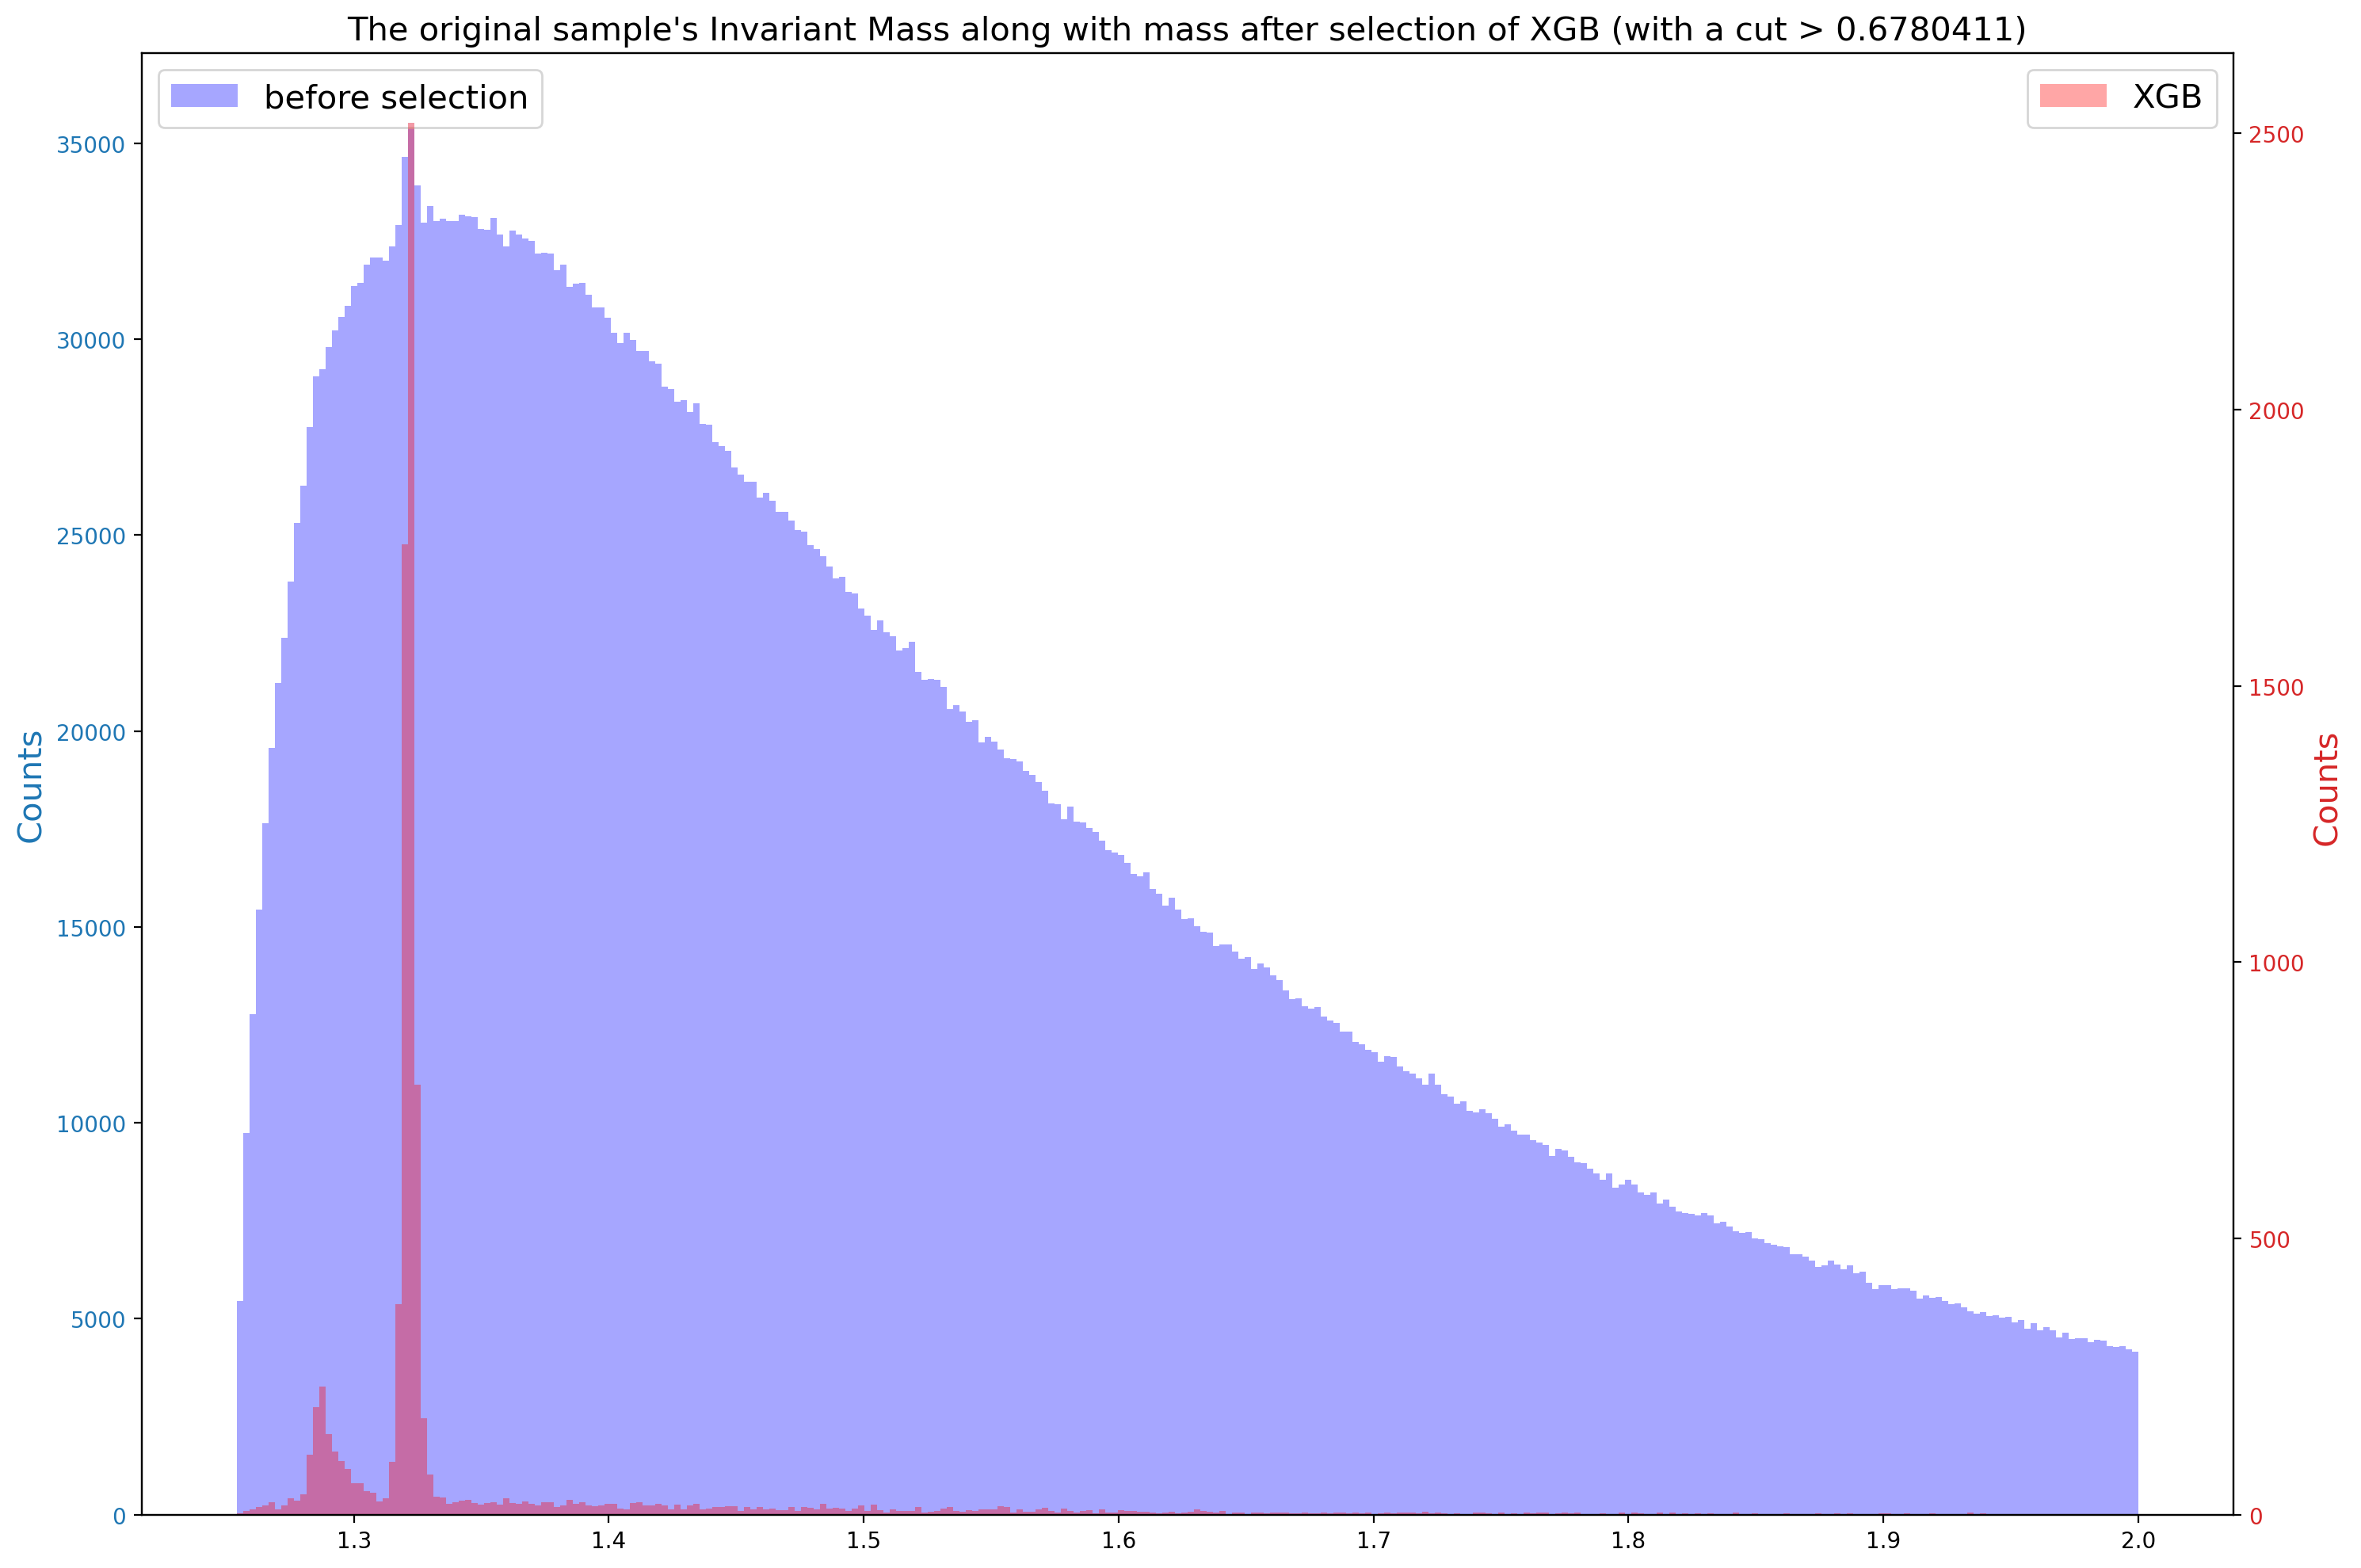

In [38]:
cut_visualization(test_best)

# Comparison with the manually optimized cuts of KFPF
In the already existing Kalman Filter Particle Finder (KFPF) package for online reconstruction and selection of short-lived particles in CBM, these criteria have been manually optimized. These selection-cuts have been selected to maximize the signal to background ratio (S/B) of the $\Lambda$ for a certain energy on a collisions generator. The selection criteria mainly depends on the collision energy, decay channel and detector configuration.

In [39]:
#manually selected cuts
manCut_loverdl = 5.0
manCut_dca = 1.0
manCut_chi2topo = 5.0
manCut_chi2geo = 6.0

In [40]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[4967    0]
 [3772    0]]


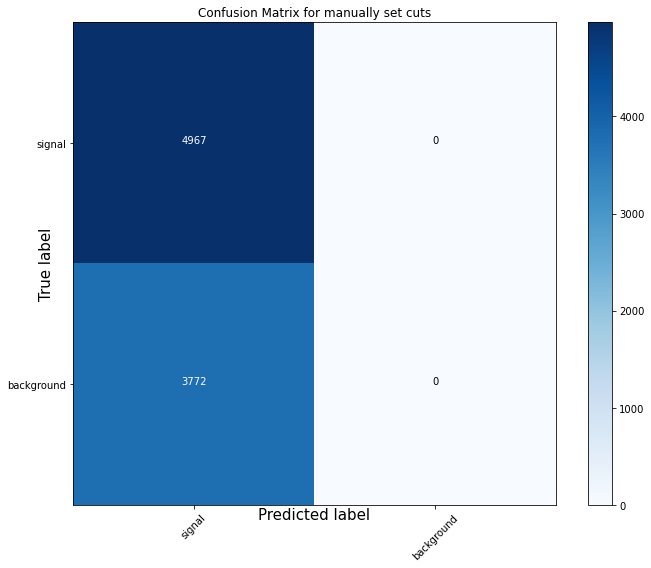

In [41]:
new_check_set= df_clean.copy()
new_check_set['new_signal']=0

mask1 = (new_check_set['loverdl'] > manCut_loverdl) & (new_check_set['distance'] < manCut_dca)

mask2 = (new_check_set['chi2topo'] < manCut_chi2topo) & (new_check_set['chi2geo'] < manCut_chi2geo)

new_check_set = new_check_set[(mask1) & (mask2)] 

#After all these cuts, what is left is considered as signal, so we replace all the values in the 'new_signal'
# column by 1
new_check_set['new_signal'] = 1
cnf_matrix1 = confusion_matrix(new_check_set['issignal'], new_check_set['new_signal'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix1, classes=['signal','background'], title='Confusion Matrix for manually set cuts')
fig.savefig(directory+'img/xgb_v3/confusion_matrix_for_manually_set_cuts.pdf')
fig.savefig(directory+'img/xgb_v3/confusion_matrix_for_manually_set_cuts.png')

In [42]:
confustion_stats(df_clean, cnf_matrix1)

Efficiency: 139.31%
Efficiency of true signal candidates reconstruction: 79.18%
False tu true reconstructed signal ratio: 0.76


In [43]:
cut3 = test_best
mask1 = df_clean['xgb_preds']>cut3
df3=df_clean[mask1]

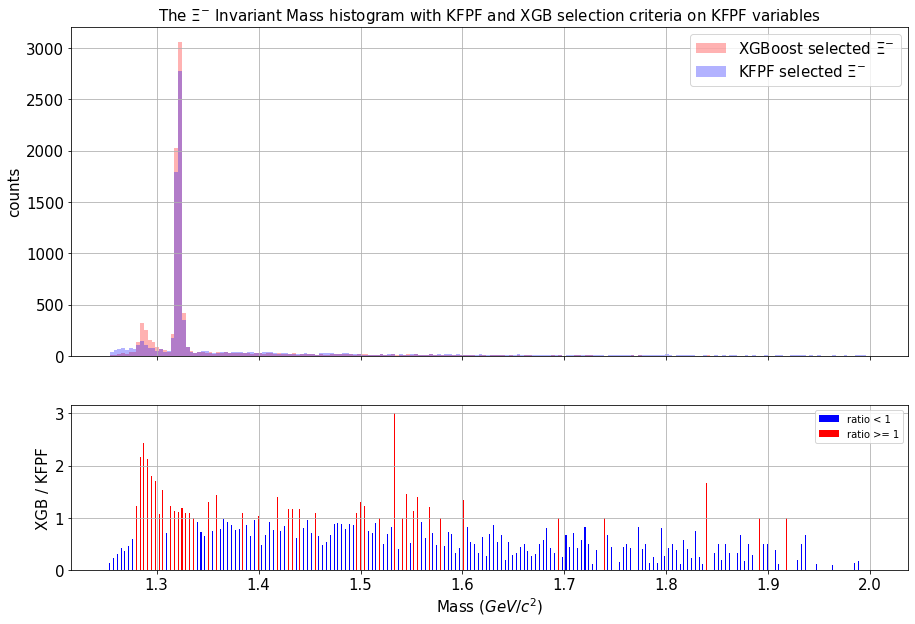

In [44]:
# from matplotlib import gridspec

range1= (lowerMassCut, upperMassCut)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 200, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 200, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost selected $\Xi^{-}$','KFPF selected $\Xi^{-}$'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The $\Xi^{-}$ Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(lowerMassCut, upperMassCut), bins=200)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(lowerMassCut, upperMassCut), bins=200)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass $(GeV/c^2)$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
#axs[1].set_ylim([0.,2.5])
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb_v3/kaon_inv_mass_comparison1.png')
fig.savefig(directory+'img/xgb_v3/kaon_inv_mass_comparison1.pdf')

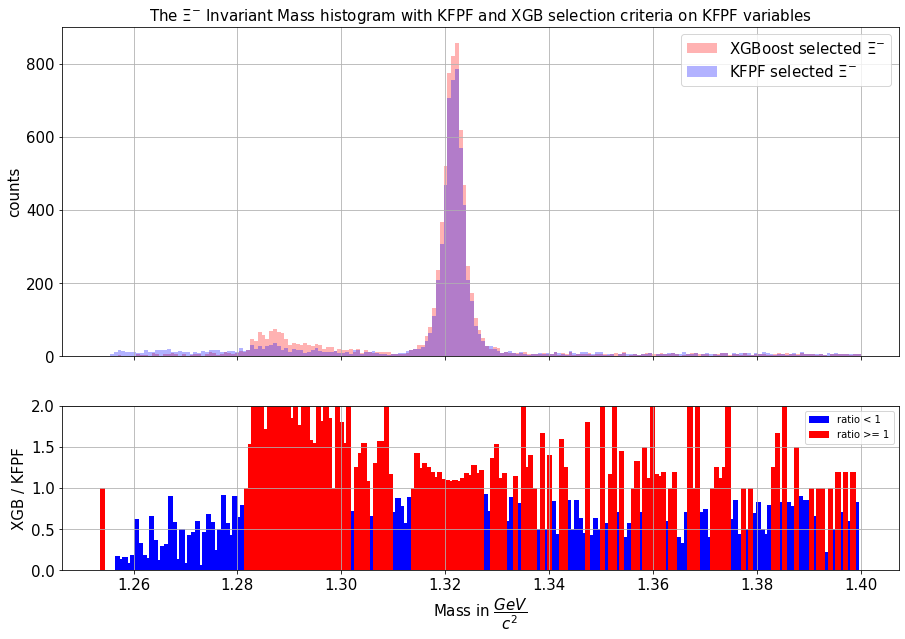

In [45]:
# from matplotlib import gridspec

range1= (lowerMassCut, upperMassCut)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 200, range=[1.254, 1.4], facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 200, range=[1.254, 1.4],facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].set_yscale('log')
axs[0].legend(('XGBoost selected $\Xi^{-}$','KFPF selected $\Xi^{-}$'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The $\Xi^{-}$ Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=[1.254, 1.4], bins=200)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=[1.254, 1.4], bins=200)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].set_ylim([0.,2.])
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb_v3/kaon_inv_mass_comparison2.png')
fig.savefig(directory+'img/xgb_v3/kaon_inv_mass_comparison2.pdf')

<ipython-input-46-5d596222c44e>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ns, bins, patches=axs[0].hist((df3['mass']),bins = 50,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
<ipython-input-46-5d596222c44e>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 50,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)


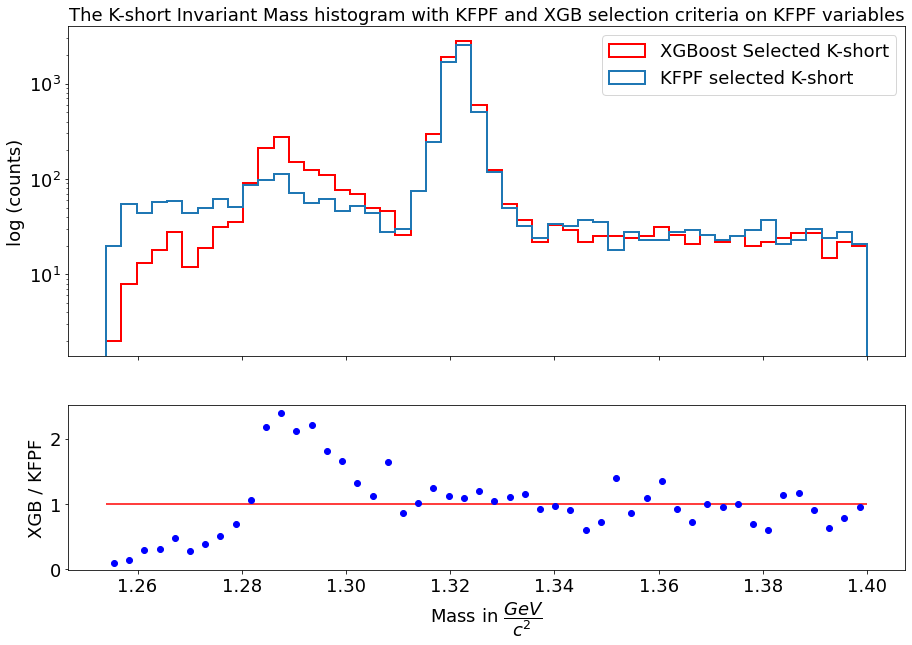

In [46]:
from matplotlib import gridspec

left = 1.254
right = 1.4
range1= (left, right)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True, gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 50,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 50,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("log (counts)", fontsize = 18)
#axs[0].grid()
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 18, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 18)
#axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[0].set_yscale('log')
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(left, right), bins=50)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(left, right), bins=50)


#makes sense to have only positive values
diff = (hist1 - hist2)
#axs[1].bar((bins[:-1] + bins[1:]) / 2, # this is what makes it comparable
# ns / ns1, # maybe check for div-by-zero!
# width=0.001)
axs[1].hlines(y=1, xmin=left, xmax=right, colors='r', linestyles='solid', label='')
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, ns / ns1, fmt='o',
                 c='Blue', label='Background in predictions')


    
    
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
axs[1].set_ylabel("XGB / KFPF", fontsize = 18)
#axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=18)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/circle_kshort_invmass_with_ML.png')

In [47]:
gc.collect()

71974